In [2]:
from pathlib import Path

p = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim\P01_R01_neurokit_rr_aligned.csv")

out = run_neurokit_validation_on_file(p, win_rr=100)

print("RR lengths:", out["rr_lab_len"], out["rr_nk_len"])
print(out["summary"])


RR lengths: 226444 226444
                        pair  n_windows  corr_csi  corr_modcsi  p99_modcsi_a  \
0  LabVIEW RR vs NeuroKit RR     226345  0.878199     0.955899   7073.447901   

   p99_modcsi_b  median_absdiff_csi  median_absdiff_modcsi  
0   6869.698674            0.040695               7.552154  


In [3]:
df = pd.read_csv(p)
print(df["RR_labview_s"].median(), df["RR_python_s"].median())


0.8491158485412598 0.849609375


In [33]:
# Study5_quick_HRV_Test_FINAL.py
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd


# ============================================================
# IO
# ============================================================
def load_rr_pair_csv(
    csv_path: Path,
    *,
    col_lab: str = "RR_labview_s",
    col_nk: str = "RR_python_s",
) -> tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path)
    rr_lab = pd.to_numeric(df[col_lab], errors="coerce").dropna().to_numpy(dtype=float)
    rr_nk  = pd.to_numeric(df[col_nk],  errors="coerce").dropna().to_numpy(dtype=float)
    return rr_lab, rr_nk


# ============================================================
# Core math: SD1/SD2, CSI, ModCSI (NeuroKit-style)
# ============================================================
def rr_median_filter_7(rr_s: np.ndarray) -> np.ndarray:
    """7-beat median filter of RR tachogram. Same length as input."""
    rr = np.asarray(rr_s, dtype=float)
    n = rr.size
    if n < 7:
        return rr.copy()
    out = np.empty(n, dtype=float)
    pad = 3
    rr_pad = np.r_[np.full(pad, rr[0]), rr, np.full(pad, rr[-1])]
    for i in range(n):
        out[i] = np.median(rr_pad[i:i + 7])
    return out


def sliding_window_view_1d(x: np.ndarray, win: int) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.size < win:
        return np.empty((0, win), dtype=float)
    return np.lib.stride_tricks.sliding_window_view(x, window_shape=win)


def poincare_sd1_sd2_vectorized(rr_ms_windows: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    rr_ms_windows: shape (nwin, win_rr)
    Returns SD1, SD2 arrays length nwin (ms).
    """
    if rr_ms_windows.size == 0:
        return np.array([]), np.array([])
    x = rr_ms_windows[:, :-1]
    y = rr_ms_windows[:, 1:]
    d = y - x
    s = y + x
    sd1 = np.std(d, axis=1, ddof=1) / np.sqrt(2.0)
    sd2 = np.std(s, axis=1, ddof=1) / np.sqrt(2.0)
    return sd1, sd2


def csi_from_sd(sd1: np.ndarray, sd2: np.ndarray) -> np.ndarray:
    return sd2 / np.maximum(sd1, 1e-12)


def modcsi_modified_from_sd(sd1: np.ndarray, sd2: np.ndarray) -> np.ndarray:
    # NeuroKit's "CSI_Modified": (4*SD2)^2 / (4*SD1) = 4*SD2^2 / SD1
    return (4.0 * (sd2 ** 2)) / np.maximum(sd1, 1e-12)


def slope_hr_ls_abs(rr_s_windows: np.ndarray) -> np.ndarray:
    """
    Least squares slope of HR (BPM) vs time (seconds) inside each window.
    - time axis: cumulative RR (beat-end times from window start)
    - HR: 60/RR_s
    Returns abs(slope) in BPM/s (Jeppesen uses abs).
    """
    if rr_s_windows.size == 0:
        return np.array([])

    rr = np.asarray(rr_s_windows, dtype=float)
    rr = np.maximum(rr, 1e-12)

    # t = cumsum(rr) per window
    t = np.cumsum(rr, axis=1)
    hr = 60.0 / rr

    # center
    t0 = t - t.mean(axis=1, keepdims=True)
    h0 = hr - hr.mean(axis=1, keepdims=True)

    denom = np.sum(t0 * t0, axis=1)
    numer = np.sum(t0 * h0, axis=1)
    slope = np.where(denom > 0, numer / denom, np.nan)

    return np.abs(slope)


# ============================================================
# Jeppesen-style features (mail-validated rules)
#   - CSI: computed on UNFILTERED RR
#   - ModCSI: computed on 7RR median-filtered RR
#   - SlopeHR: computed on HR (BPM) using filtered RR
#   - Products: CSI×SlopeHR and ModCSI(filt)×SlopeHR
# ============================================================
def compute_jeppesen_features(rr_s: np.ndarray, *, win_rr: int = 100) -> pd.DataFrame:
    rr_s = pd.to_numeric(pd.Series(rr_s), errors="coerce").dropna().to_numpy(dtype=float)
    if rr_s.size < win_rr:
        return pd.DataFrame()

    rr_f = rr_median_filter_7(rr_s)

    W_raw = sliding_window_view_1d(rr_s, win_rr)       # seconds
    W_f   = sliding_window_view_1d(rr_f, win_rr)       # seconds

    rr_raw_ms = W_raw * 1000.0
    rr_f_ms   = W_f * 1000.0

    sd1_raw, sd2_raw = poincare_sd1_sd2_vectorized(rr_raw_ms)
    sd1_f,   sd2_f   = poincare_sd1_sd2_vectorized(rr_f_ms)

    csi_raw = csi_from_sd(sd1_raw, sd2_raw)               # unfiltered (per Jesper)
    modcsi_f = modcsi_modified_from_sd(sd1_f, sd2_f)      # filtered (per Jesper)

    slopeHR = slope_hr_ls_abs(W_f)                        # HR slope on filtered RR

    # time at END of window (seconds since start of RR series)
    t_end_s = np.cumsum(rr_s)[win_rr - 1 :]

    df = pd.DataFrame({
        "t_end_s": t_end_s,
        "CSI100": csi_raw,
        "ModCSI100_filt": modcsi_f,
        "SlopeHR100": slopeHR,
    })
    df["CSI100_x_SlopeHR"] = df["CSI100"] * df["SlopeHR100"]
    df["ModCSI100filt_x_SlopeHR"] = df["ModCSI100_filt"] * df["SlopeHR100"]
    return df


# ============================================================
# NeuroKit "internal" CSI/ModCSI (fast equivalent)
#   - We compute SD1/SD2 on RR windows and report:
#       NK_CSI = SD2/SD1
#       NK_ModCSI = 4*SD2^2/SD1
#   - This matches NeuroKit’s HRV_CSI and HRV_CSI_Modified definitions.
# ============================================================
def compute_neurokit_equiv_csi_modcsi(rr_s: np.ndarray, *, win_rr: int = 100) -> pd.DataFrame:
    rr_s = pd.to_numeric(pd.Series(rr_s), errors="coerce").dropna().to_numpy(dtype=float)
    if rr_s.size < win_rr:
        return pd.DataFrame()

    W = sliding_window_view_1d(rr_s * 1000.0, win_rr)  # ms
    sd1, sd2 = poincare_sd1_sd2_vectorized(W)
    csi = csi_from_sd(sd1, sd2)
    modcsi = modcsi_modified_from_sd(sd1, sd2)
    t_end_s = np.cumsum(rr_s)[win_rr - 1 :]

    return pd.DataFrame({
        "t_end_s": t_end_s,
        "NK_CSI": csi,
        "NK_ModCSI": modcsi,
        "NK_SD1": sd1,
        "NK_SD2": sd2,
    })


# ============================================================
# Threshold helper: 1.05 * max(value) in segments
# ============================================================
def auto_thresholds_from_series(
    df_feat: pd.DataFrame,
    value_col: str,
    *,
    factor: float = 1.05,
    first_12h_s: float = 12 * 3600,
    first_24h_s: float = 24 * 3600,
) -> pd.DataFrame:
    if df_feat.empty or value_col not in df_feat.columns:
        return pd.DataFrame()

    t = df_feat["t_end_s"].to_numpy(dtype=float)
    v = pd.to_numeric(df_feat[value_col], errors="coerce").to_numpy(dtype=float)

    if not np.any(np.isfinite(t)) or not np.any(np.isfinite(v)):
        return pd.DataFrame()

    t_max = float(np.nanmax(t))
    half = 0.5 * t_max

    def seg(mode: str, a: float, b: float):
        b = min(b, t_max)
        m = (t >= a) & (t <= b) & np.isfinite(v)
        mx = float(np.nanmax(v[m])) if np.any(m) else np.nan
        thr = float(factor * mx) if np.isfinite(mx) else np.nan
        return {
            "mode_used": mode,
            "segment_start_s": float(a),
            "segment_end_s": float(b),
            "max_value_in_segment": mx,
            "factor": float(factor),
            "threshold": thr,
        }

    return pd.DataFrame([
        seg("first_12h", 0.0, first_12h_s),
        seg("first_24h", 0.0, first_24h_s),
        seg("first_half", 0.0, half),
    ])


# ============================================================
# VALIDATION A: RR source comparability
#   Same feature definition (Jeppesen) on two RR sources
# ============================================================
def validate_A_rr_sources(rr_lab_s: np.ndarray, rr_nk_s: np.ndarray, *, win_rr: int = 100) -> pd.DataFrame:
    a = compute_jeppesen_features(rr_lab_s, win_rr=win_rr).add_suffix("_lab")
    b = compute_jeppesen_features(rr_nk_s,  win_rr=win_rr).add_suffix("_nk")

    n = min(len(a), len(b))
    if n == 0:
        return pd.DataFrame([{"pair": "LabVIEW RR vs NeuroKit RR", "n_windows": 0}])

    a = a.iloc[:n].reset_index(drop=True)
    b = b.iloc[:n].reset_index(drop=True)

    pairs = [
        ("CSI100_lab", "CSI100_nk"),
        ("ModCSI100_filt_lab", "ModCSI100_filt_nk"),
        ("SlopeHR100_lab", "SlopeHR100_nk"),
        ("CSI100_x_SlopeHR_lab", "CSI100_x_SlopeHR_nk"),
        ("ModCSI100filt_x_SlopeHR_lab", "ModCSI100filt_x_SlopeHR_nk"),
    ]

    rows = []
    for x, y in pairs:
        xv = pd.to_numeric(a[x], errors="coerce").to_numpy(dtype=float)
        yv = pd.to_numeric(b[y], errors="coerce").to_numpy(dtype=float)
        m = np.isfinite(xv) & np.isfinite(yv)
        corr = float(np.corrcoef(xv[m], yv[m])[0, 1]) if m.sum() >= 3 else np.nan
        mad = float(np.nanmedian(np.abs(xv[m] - yv[m]))) if m.any() else np.nan
        rows.append({"comparison": f"{x} vs {y}", "n": int(m.sum()), "corr": corr, "median_absdiff": mad})

    out = pd.DataFrame(rows)
    out.insert(0, "pair", "LabVIEW RR vs NeuroKit RR")
    out.insert(1, "win_rr", int(win_rr))
    return out


# ============================================================
# VALIDATION B: Feature definition comparability
#   Same RR source, compare:
#     - Jeppesen-feature CSI/ModCSI (rules from mail)
#     - NeuroKit-equivalent CSI/ModCSI (SD1/SD2 formula)
#   NOTE: We compare CSI100 (unfiltered) vs NK_CSI (unfiltered) and
#         ModCSI100_filt vs NK_ModCSI (unfiltered) are NOT supposed to match
#         unless you explicitly compare against filtered RR variant.
# ============================================================
def validate_B_feature_defs(rr_s: np.ndarray, *, win_rr: int = 100) -> pd.DataFrame:
    ours = compute_jeppesen_features(rr_s, win_rr=win_rr)
    nk_u = compute_neurokit_equiv_csi_modcsi(rr_s, win_rr=win_rr)

    n = min(len(ours), len(nk_u))
    if n == 0:
        return pd.DataFrame([{"win_rr": win_rr, "n_windows": 0}])

    ours = ours.iloc[:n].reset_index(drop=True)
    nk_u = nk_u.iloc[:n].reset_index(drop=True)

    # Compare CSI (both unfiltered)
    csi_corr = float(np.corrcoef(ours["CSI100"], nk_u["NK_CSI"])[0, 1])
    csi_mad  = float(np.median(np.abs(ours["CSI100"] - nk_u["NK_CSI"])))

    # Compare ModCSI: ours is FILTERED, nk_u is UNFILTERED -> expect mismatch (but useful diagnostic)
    mod_corr = float(np.corrcoef(ours["ModCSI100_filt"], nk_u["NK_ModCSI"])[0, 1])
    mod_mad  = float(np.median(np.abs(ours["ModCSI100_filt"] - nk_u["NK_ModCSI"])))

    return pd.DataFrame([{
        "win_rr": int(win_rr),
        "n_windows": int(n),
        "corr_CSI_ours_vs_NK": csi_corr,
        "median_absdiff_CSI": csi_mad,
        "corr_ModCSI_filt_vs_NK_unfilt": mod_corr,
        "median_absdiff_ModCSI": mod_mad,
        "p99_CSI_ours": float(np.nanpercentile(ours["CSI100"], 99)),
        "p99_CSI_NK": float(np.nanpercentile(nk_u["NK_CSI"], 99)),
        "p99_ModCSI_filt_ours": float(np.nanpercentile(ours["ModCSI100_filt"], 99)),
        "p99_ModCSI_NK_unfilt": float(np.nanpercentile(nk_u["NK_ModCSI"], 99)),
    }])


# ============================================================
# Wrapper: run A + B + thresholds (explicitly separated)
# ============================================================
@dataclass(frozen=True)
class HRVQuickTestConfig:
    win_rr: int = 100
    factor: float = 1.05
    col_lab: str = "RR_labview_s"
    col_nk: str = "RR_python_s"


def run_quick_hrv_test(csv_path: Path, cfg: HRVQuickTestConfig = HRVQuickTestConfig()) -> dict:
    rr_lab, rr_nk = load_rr_pair_csv(csv_path, col_lab=cfg.col_lab, col_nk=cfg.col_nk)

    # A) RR source validation: Jeppesen features on both RR sources
    df_A = validate_A_rr_sources(rr_lab, rr_nk, win_rr=cfg.win_rr)

    # B) Feature definition validation (per RR source)
    df_B_lab = validate_B_feature_defs(rr_lab, win_rr=cfg.win_rr)
    df_B_lab.insert(0, "RR_source", "LabVIEW_RR")

    df_B_nk = validate_B_feature_defs(rr_nk, win_rr=cfg.win_rr)
    df_B_nk.insert(0, "RR_source", "NeuroKit_RR")

    df_B = pd.concat([df_B_lab, df_B_nk], ignore_index=True)

    # Features (Jeppesen) for thresholding + plotting
    feat_lab = compute_jeppesen_features(rr_lab, win_rr=cfg.win_rr)
    feat_nk  = compute_jeppesen_features(rr_nk,  win_rr=cfg.win_rr)

    # Threshold tables for two key products (the ones you care about in Study5)
    tabs = []
    for label, feat in [("LabVIEW_RR", feat_lab), ("NeuroKit_RR", feat_nk)]:
        for value_col in ["ModCSI100filt_x_SlopeHR", "CSI100_x_SlopeHR"]:
            tab = auto_thresholds_from_series(feat, value_col, factor=cfg.factor)
            tab.insert(0, "RR_source", label)
            tab.insert(1, "value_col", value_col)
            tabs.append(tab)
    df_thr = pd.concat(tabs, ignore_index=True) if tabs else pd.DataFrame()

    return {
        "csv_path": str(csv_path),
        "rr_len_lab": int(rr_lab.size),
        "rr_len_nk": int(rr_nk.size),
        "A_rr_sources": df_A,
        "B_feature_defs": df_B,
        "thresholds": df_thr,
        "feat_lab_jeppesen": feat_lab,
        "feat_nk_jeppesen": feat_nk,
    }


# ============================================================
# Optional plotting (keep simple)
# ============================================================
def plot_time_series(
    feat: pd.DataFrame,
    *,
    cols: tuple[str, ...] = ("ModCSI100filt_x_SlopeHR", "CSI100_x_SlopeHR"),
    t0_s: float = 0.0,
    t1_s: float | None = None,
    title: str = "",
):
    import matplotlib.pyplot as plt

    if feat.empty:
        print("No features to plot.")
        return

    t = feat["t_end_s"].to_numpy(dtype=float)
    if t1_s is None:
        t1_s = float(np.nanmax(t))

    m = (t >= t0_s) & (t <= t1_s)
    if not np.any(m):
        print("No samples in requested interval.")
        return

    plt.figure()
    for c in cols:
        if c in feat.columns:
            plt.plot(t[m] / 60.0, feat.loc[m, c].to_numpy(dtype=float), label=c)
    plt.xlabel("Time [min]")
    plt.ylabel("Value")
    plt.title(title or f"{t0_s/60:.1f}–{t1_s/60:.1f} min")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_around_seizure(
    feat: pd.DataFrame,
    *,
    seiz_t0_s: float,
    seiz_t1_s: float,
    pad_s: float = 30 * 60,
    title: str = "Around seizure",
):
    import matplotlib.pyplot as plt

    a = max(0.0, float(seiz_t0_s - pad_s))
    b = float(seiz_t1_s + pad_s)
    t = feat["t_end_s"].to_numpy(dtype=float)
    m = (t >= a) & (t <= b)

    plt.figure()
    plt.plot(t[m] / 60.0, feat.loc[m, "ModCSI100filt_x_SlopeHR"], label="ModCSI×SlopeHR")
    plt.plot(t[m] / 60.0, feat.loc[m, "CSI100_x_SlopeHR"], label="CSI×SlopeHR", alpha=0.8)
    plt.axvspan(seiz_t0_s / 60.0, seiz_t1_s / 60.0, alpha=0.2, label="Seizure")
    plt.xlabel("Time [min]")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()



RR lengths: 226444 226444

A) RR source validation (Jeppesen features on both RR sources):
                        pair  win_rr  \
0  LabVIEW RR vs NeuroKit RR     100   
1  LabVIEW RR vs NeuroKit RR     100   
2  LabVIEW RR vs NeuroKit RR     100   
3  LabVIEW RR vs NeuroKit RR     100   
4  LabVIEW RR vs NeuroKit RR     100   

                                          comparison       n      corr  \
0                            CSI100_lab vs CSI100_nk  226345  0.878199   
1            ModCSI100_filt_lab vs ModCSI100_filt_nk  226345  0.999449   
2                    SlopeHR100_lab vs SlopeHR100_nk  226345  0.999478   
3        CSI100_x_SlopeHR_lab vs CSI100_x_SlopeHR_nk  226345  0.964157   
4  ModCSI100filt_x_SlopeHR_lab vs ModCSI100filt_x...  226345  0.999575   

   median_absdiff  
0        0.040695  
1       13.547599  
2        0.000437  
3        0.002242  
4        0.705513  

B) Feature definition validation (Jeppesen vs NeuroKit-equivalent):
     RR_source  win_rr  n_windows 

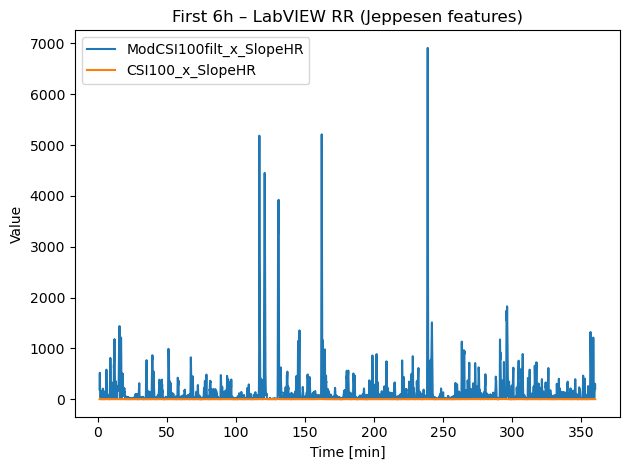

In [35]:
p = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim\P01_R01_neurokit_rr_aligned.csv")
out = run_quick_hrv_test(p, HRVQuickTestConfig(win_rr=100, factor=1.05))

print("RR lengths:", out["rr_len_lab"], out["rr_len_nk"])
print("\nA) RR source validation (Jeppesen features on both RR sources):")
print(out["A_rr_sources"])

print("\nB) Feature definition validation (Jeppesen vs NeuroKit-equivalent):")
print(out["B_feature_defs"])

print("\nThresholds (105% of max in segments):")
print(out["thresholds"])

# Quick plot: first 6 hours (LabVIEW RR)
plot_time_series(
    out["feat_lab_jeppesen"],
    t0_s=0,
    t1_s=6 * 3600,
    title="First 6h – LabVIEW RR (Jeppesen features)",
)

In [5]:
p = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim\P01_R01_neurokit_rr_aligned.csv")
out = run_file_ab_test(p, win_rr=100)

print("Threshold table (head):")
display(out["thresholds"].head(30))

# Hvis du vil gemme:
out["thresholds"].to_csv(r"E:\Speciale - Results\study5_out\threshold_compare_P01_R01.csv", index=False)


Threshold table (head):


,RR_source,value_col,mode,seg_start_s,seg_end_s,max_value,factor,threshold
0,LabVIEW_RR,CSI100,first_12h,0.0,43200.000000,16.545954,1.05,17.373251
1,LabVIEW_RR,CSI100,first_24h,0.0,86400.000000,24.636410,1.05,25.868230
2,LabVIEW_RR,CSI100,first_half,0.0,95206.103520,24.636410,1.05,25.868230
3,LabVIEW_RR,ModCSI100_filt,first_12h,0.0,43200.000000,15410.475785,1.05,16180.999575
4,LabVIEW_RR,ModCSI100_filt,first_24h,0.0,86400.000000,21934.320854,1.05,23031.036897
5,LabVIEW_RR,ModCSI100_filt,first_half,0.0,95206.103520,21934.320854,1.05,23031.036897
6,LabVIEW_RR,SlopeHR100,first_12h,0.0,43200.000000,0.451150,1.05,0.473707
7,LabVIEW_RR,SlopeHR100,first_24h,0.0,86400.000000,0.939220,1.05,0.986181
8,LabVIEW_RR,SlopeHR100,first_half,0.0,95206.103520,0.939220,1.05,0.986181
9,LabVIEW_RR,CSI100_x_SlopeHR,first_12h,0.0,43200.000000,7.431307,1.05,7.802872


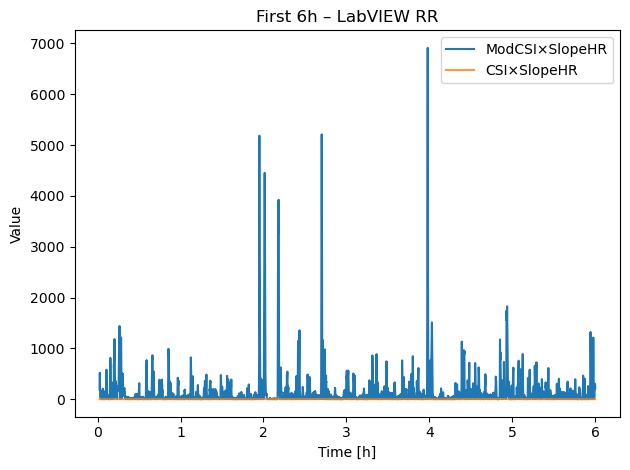

In [6]:
import matplotlib.pyplot as plt

feat = out["feat_lab"]  # eller feat_nk
mask = feat["t_end_s"] <= 6*3600

plt.figure()
plt.plot(feat.loc[mask, "t_end_s"]/3600, feat.loc[mask, "ModCSI100filt_x_SlopeHR"], label="ModCSI×SlopeHR")
plt.plot(feat.loc[mask, "t_end_s"]/3600, feat.loc[mask, "CSI100_x_SlopeHR"], label="CSI×SlopeHR", alpha=0.8)
plt.xlabel("Time [h]")
plt.ylabel("Value")
plt.title("First 6h – LabVIEW RR")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
def plot_around_interval(feat: pd.DataFrame, t0: float, t1: float, pad_s: float = 30*60):
    import matplotlib.pyplot as plt
    a = max(0.0, t0 - pad_s)
    b = t1 + pad_s
    m = (feat["t_end_s"] >= a) & (feat["t_end_s"] <= b)

    plt.figure()
    plt.plot(feat.loc[m, "t_end_s"]/60, feat.loc[m, "ModCSI100filt_x_SlopeHR"], label="ModCSI×SlopeHR")
    plt.plot(feat.loc[m, "t_end_s"]/60, feat.loc[m, "CSI100_x_SlopeHR"], label="CSI×SlopeHR", alpha=0.8)
    plt.axvspan(t0/60, t1/60, alpha=0.2, label="Seizure interval")
    plt.xlabel("Time [min]")
    plt.ylabel("Value")
    plt.title("Around seizure")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [25]:
import numpy as np
import pandas as pd
import neurokit2 as nk

def compute_neurokit_csi_modcsi(rr_s: np.ndarray, *, win_rr: int = 100) -> pd.DataFrame:
    rr_s = pd.to_numeric(pd.Series(rr_s), errors="coerce").dropna().to_numpy(dtype=float)
    if rr_s.size < win_rr:
        return pd.DataFrame()

    rr_ms = rr_s * 1000.0
    W = np.lib.stride_tricks.sliding_window_view(rr_ms, window_shape=win_rr)
    n = W.shape[0]

    csi = np.empty(n, dtype=float)
    modcsi = np.empty(n, dtype=float)

    for i in range(n):
        rri = W[i]  # ms
        peaks = nk.intervals_to_peaks(rri, sampling_rate=1000)
        out = nk.hrv_nonlinear(peaks, sampling_rate=1000, show=False)

        # handle both naming conventions
        csi_col = "CSI" if "CSI" in out.columns else ("HRV_CSI" if "HRV_CSI" in out.columns else None)
        mod_col = (
            "CSI_Modified" if "CSI_Modified" in out.columns else
            ("HRV_CSI_Modified" if "HRV_CSI_Modified" in out.columns else None)
        )

        if csi_col is None or mod_col is None:
            raise KeyError(f"NeuroKit output missing CSI columns. Columns: {list(out.columns)}")

        csi[i] = float(out[csi_col].iloc[0])
        modcsi[i] = float(out[mod_col].iloc[0])

    t_end_s = np.cumsum(rr_s)[win_rr - 1 :]
    return pd.DataFrame({"t_end_s": t_end_s, "NK_CSI": csi, "NK_ModCSI": modcsi})

import numpy as np
import pandas as pd

def compute_csi_modcsi_vectorized(rr_s: np.ndarray, *, win_rr: int = 100) -> pd.DataFrame:
    rr_s = pd.to_numeric(pd.Series(rr_s), errors="coerce").dropna().to_numpy(dtype=float)
    if rr_s.size < win_rr:
        return pd.DataFrame()

    rr_ms = rr_s * 1000.0
    W = np.lib.stride_tricks.sliding_window_view(rr_ms, window_shape=win_rr)  # (nwin, 100)

    x = W[:, :-1]
    y = W[:, 1:]
    d = y - x
    s = y + x

    sd1 = np.std(d, axis=1, ddof=1) / np.sqrt(2.0)
    sd2 = np.std(s, axis=1, ddof=1) / np.sqrt(2.0)

    csi = sd2 / np.maximum(sd1, 1e-12)
    modcsi = 4.0 * (sd2**2) / np.maximum(sd1, 1e-12)  # same as (L^2/T) with L=4sd2, T=4sd1

    t_end_s = np.cumsum(rr_s)[win_rr - 1 :]

    return pd.DataFrame({
        "t_end_s": t_end_s,
        "CSI": csi,
        "ModCSI": modcsi,
        "SD1": sd1,
        "SD2": sd2,
    })

def compute_nk_equiv_features(rr_s: np.ndarray, *, win_rr: int = 100) -> pd.DataFrame:
    nk = compute_csi_modcsi_vectorized(rr_s, win_rr=win_rr)
    if nk.empty:
        return nk
    return nk.rename(columns={
        "CSI": "NK_CSI",
        "ModCSI": "NK_ModCSI",
        "SD1": "NK_SD1",
        "SD2": "NK_SD2",
        "t_end_s": "t_s",
    })


In [26]:
def validate_A_rr_sources(rr_lab_s, rr_nk_s, *, win_rr=100) -> pd.DataFrame:
    a = compute_jeppesen_features(rr_lab_s, win_rr=win_rr).add_suffix("_lab")
    b = compute_jeppesen_features(rr_nk_s,  win_rr=win_rr).add_suffix("_nk")

    n = min(len(a), len(b))
    a = a.iloc[:n].reset_index(drop=True)
    b = b.iloc[:n].reset_index(drop=True)

    # columns to compare
    pairs = [
        ("CSI100_lab", "CSI100_nk"),
        ("ModCSI100_filt_lab", "ModCSI100_filt_nk"),
        ("SlopeHR100_lab", "SlopeHR100_nk"),
        ("CSI100_x_SlopeHR_lab", "CSI100_x_SlopeHR_nk"),
        ("ModCSI100filt_x_SlopeHR_lab", "ModCSI100filt_x_SlopeHR_nk"),
    ]

    rows = []
    for x, y in pairs:
        xv = a[x].to_numpy()
        yv = b[y].to_numpy()
        m = np.isfinite(xv) & np.isfinite(yv)
        corr = np.corrcoef(xv[m], yv[m])[0,1] if m.sum() > 3 else np.nan
        mad  = np.median(np.abs(xv[m] - yv[m])) if m.any() else np.nan
        rows.append({"comparison": f"{x} vs {y}", "n": int(m.sum()), "corr": corr, "median_absdiff": mad})

    return pd.DataFrame(rows)


In [32]:
import numpy as np
import pandas as pd

def validate_B_feature_defs(rr_s, *, win_rr=100) -> pd.DataFrame:
    ours = compute_jeppesen_features(rr_s, win_rr=win_rr)      # returns CSI100, ModCSI100_filt, ...
    nkdf = compute_nk_equiv_features(rr_s, win_rr=win_rr)      # returns NK_CSI, NK_ModCSI, t_s, ...

    # Align length (and keep consistent)
    n = min(len(ours), len(nkdf))
    ours = ours.iloc[:n].reset_index(drop=True)
    nkdf  = nkdf.iloc[:n].reset_index(drop=True)

    # Safety checks
    need_ours = {"CSI100", "ModCSI100_filt"}
    need_nk   = {"NK_CSI", "NK_ModCSI"}
    miss = (need_ours - set(ours.columns)) | (need_nk - set(nkdf.columns))
    if miss:
        raise KeyError(f"Missing expected columns: {miss}")

    out = pd.DataFrame([{
        "n_windows": n,

        "corr_CSI": float(np.corrcoef(ours["CSI100"], nkdf["NK_CSI"])[0, 1]),
        "corr_ModCSI": float(np.corrcoef(ours["ModCSI100_filt"], nkdf["NK_ModCSI"])[0, 1]),

        "median_absdiff_CSI": float(np.median(np.abs(ours["CSI100"] - nkdf["NK_CSI"]))),
        "median_absdiff_ModCSI": float(np.median(np.abs(ours["ModCSI100_filt"] - nkdf["NK_ModCSI"]))),

        "p99_CSI_ours": float(np.nanpercentile(ours["CSI100"], 99)),
        "p99_CSI_nk": float(np.nanpercentile(nkdf["NK_CSI"], 99)),

        "p99_ModCSI_ours": float(np.nanpercentile(ours["ModCSI100_filt"], 99)),
        "p99_ModCSI_nk": float(np.nanpercentile(nkdf["NK_ModCSI"], 99)),
    }])

    return out


In [31]:
p = r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim\P01_R01_neurokit_rr_aligned.csv"
df = pd.read_csv(p)
rr_lab = df["RR_labview_s"].to_numpy()
rr_nk  = df["RR_python_s"].to_numpy()

# A) RR-kilde-validering (feature fast)
df_A = validate_A_rr_sources(rr_lab, rr_nk, win_rr=100)
display(df_A)

# B1) Feature-validering på LabVIEW RR (RR fast)
df_B1 = validate_B_feature_defs(rr_lab, win_rr=100)
display(df_B1)

# B2) Feature-validering på NeuroKit RR (RR fast)
df_B2 = validate_B_feature_defs(rr_nk, win_rr=100)
display(df_B2)

,comparison,n,corr,median_absdiff
0,CSI100_lab vs CSI100_nk,226345,0.878199,0.040695
1,ModCSI100_filt_lab vs ModCSI100_filt_nk,226345,0.999449,13.547599
2,SlopeHR100_lab vs SlopeHR100_nk,226345,0.999478,0.000437
3,CSI100_x_SlopeHR_lab vs CSI100_x_SlopeHR_nk,226345,0.964157,0.002242
4,ModCSI100filt_x_SlopeHR_lab vs ModCSI100filt_x...,226345,0.999575,0.705513


OURS columns: ['t_end_s', 'CSI100', 'ModCSI100_filt', 'SlopeHR100', 'CSI100_x_SlopeHR', 'ModCSI100filt_x_SlopeHR']
NK columns: ['t_s', 'NK_CSI', 'NK_ModCSI', 'NK_SD1', 'NK_SD2']


KeyError: 'ModCSI100'